In [1]:
import numpy as np
from matplotlib import pyplot as plt
import csv
import tensorflow as tf
import time

In [2]:
tf.keras.backend.clear_session()

In [3]:
Image = np.loadtxt('Q1_Train_Data.csv', delimiter = ',', dtype='str')

In [4]:
Image = Image[1:]

In [5]:
X = [] #All Images
Y = [] #All Emotions corresponding to the images
for i in range(28709):
    H = np.reshape(np.asarray(Image[i][1].split(' '), dtype="float"), (48,48))
    #Image normalization
    max_ele = H.max()
    min_ele = H.min()
    H = (H-min_ele)/(max_ele - min_ele + 0.000000000001)
    X.append(H)
    Y.append(int(Image[i][0]))


In [6]:
Image_valid = np.loadtxt('Q1_Test_Data.csv', delimiter = ',', dtype='str')
Image_valid = Image_valid[1:]
Emotions_valid = Image_valid[:,0]

In [7]:
X_valid = []
Y_valid = []
for i in range(3588):
    H = np.reshape(np.asarray(Image_valid[i][1].split(' '), dtype="float"), (48,48))
    max_ele = H.max()
    min_ele = H.min()
    H = (H-min_ele)/(max_ele - min_ele + 0.000000000001)
    X_valid.append(H)
    Y_valid.append(Image_valid[i][0])

X_valid = np.array(X_valid)
X_valid = X_valid.reshape(X_valid.shape[0], 48, 48, 1)
Y_valid = tf.keras.utils.to_categorical(Y_valid, 7)

In [8]:
Image_test = np.loadtxt('Q1_Validation_Data.csv', delimiter = ',', dtype='str')
Image_test = Image_test[1:]
Emotions_test = Image_test[:,0]

In [47]:
X_test = []
Y_test = []
for i in range(3588):
    H = np.reshape(np.asarray(Image_test[i][1].split(' '), dtype="float"), (48,48))
    max_ele = H.max()
    min_ele = H.min()
    H = (H-min_ele)/(max_ele - min_ele + 0.000000000001)
    X_test.append(H)
    Y_test.append(Image_test[i][0])

X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)
Y_test = tf.keras.utils.to_categorical(Y_test, 7)

### (a) (1 points) Visualization:
Randomly select and visualize 1-2 images per emotion.

<Figure size 640x480 with 0 Axes>

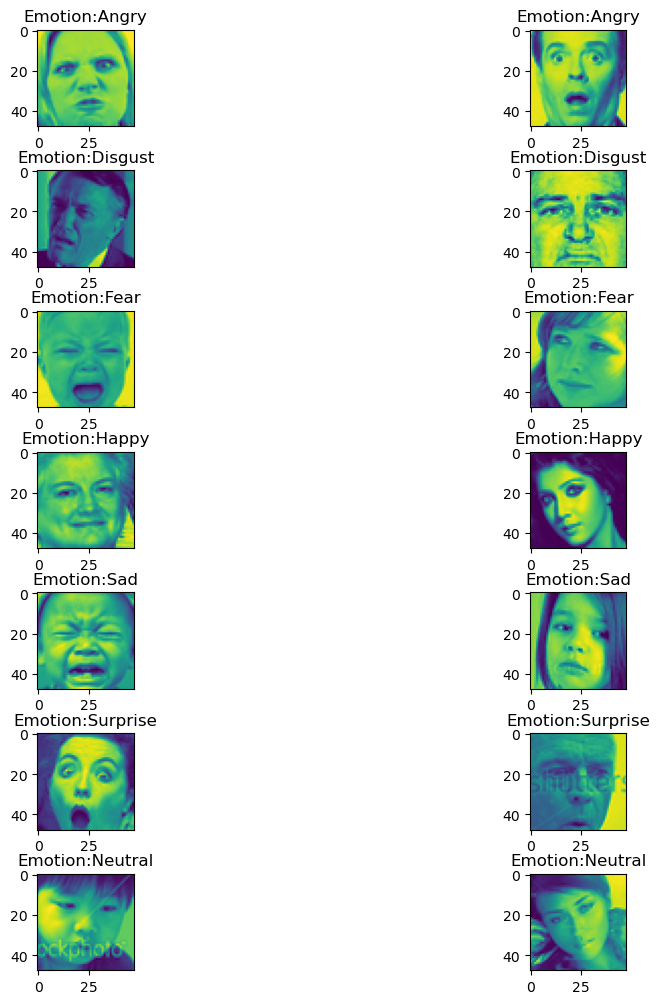

In [10]:
Emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
Temp = {}
for i in range(7):
    Temp[Emotions[i]] = [X[x] for x in range(len(X)) if int(Y[x])==i]
plt.figure()
fig, ax = plt.subplots(7,2, figsize=(10,10))
fig.tight_layout()
for i in range(7):
    ax[i, 0].set_title("Emotion:{}".format(Emotions[i]))
    ax[i, 0].imshow(Temp[Emotions[i]][20])
    ax[i, 1].set_title("Emotion:{}".format(Emotions[i]))
    ax[i, 1].imshow(Temp[Emotions[i]][25])

plt.show()

### (b) (1 points) Data exploration: 
Count the number of samples per emotion in the training
data.

In [11]:
import collections
C = collections.Counter(Y)
print(C)

Counter({3: 7215, 6: 4965, 4: 4830, 2: 4097, 0: 3995, 5: 3171, 1: 436})


In [12]:
X = np.array(X)
X = X.reshape(X.shape[0], 48, 48, 1)
Y = tf.keras.utils.to_categorical(Y, 7)

### (c) (4 points) Image classification with FNNs: 
In this part, you will use a feedforward neural network (FNN) (also called \multilayer perceptron") to perform the emotion classification task. The input of the FNN comprises of all the pixels of the image.

### (c.i) (3 points) 
Experiment on the validation set with dierent FNN hyper-parameters, e.g. #layers, #nodes per layer, activation function, dropout, weight regularization, etc. For each hyper-parameter combination that you have used, please report the following:
(1) emotion classification accuracy on the training and validation sets;
(2) running time for training the FNN;
(3) # parameters for each FNN. For 2-3 hyper-parameter combinations, please also plot the cross-entropy loss over the number of iterations during training. 

Note: If running the FNN takes a long time, you can subsample the input images to a smaller size (e.g., 24  24).

### Note: 
Thoughout the next few FNN models, the total number of parameters have been kept constant ~1.3 million so that it fits in my laptop memory and is trained within a reasonable amount of time.

### Model 1:
2 Hidden layers with 500 and 400 neurons and Relu as activation function in each hidden layer. Loss function is cross-entropy and last layers uses softmax for activation and classification. A callback function for early stopping is added (it would stop the execution once accuracy doesnt change for more than 0.002 for atmost 5 iterations) 

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, min_delta=0.002)

model1 = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(48,48,1), batch_size=None),
                              tf.keras.layers.Flatten(),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.15),
                             tf.keras.layers.Dense(500, activation=tf.nn.relu),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.15),
                             tf.keras.layers.Dense(400, activation=tf.nn.relu),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.15)])
model1.add(tf.keras.layers.Dense(len(C.keys()), activation='softmax'))
model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
              , optimizer='Adam', metrics=['accuracy'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2304)              9216      
_________________________________________________________________
dropout (Dropout)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               1152500   
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               2

In [14]:
startTime = time.time()
history1 = model1.fit(X, Y, epochs = 250, verbose=1, callbacks = [callback])
endTime = time.time()

Epoch 1/250
898/898 [==============================] - 5s 5ms/step - loss: 1.8384 - accuracy: 0.3130
Epoch 2/250
898/898 [==============================] - 4s 5ms/step - loss: 1.8021 - accuracy: 0.3526
Epoch 3/250
898/898 [==============================] - 4s 5ms/step - loss: 1.7859 - accuracy: 0.3709
Epoch 4/250
898/898 [==============================] - 5s 5ms/step - loss: 1.7749 - accuracy: 0.3801
Epoch 5/250
898/898 [==============================] - 5s 5ms/step - loss: 1.7653 - accuracy: 0.3901
Epoch 6/250
898/898 [==============================] - 4s 5ms/step - loss: 1.7569 - accuracy: 0.3987
Epoch 7/250
898/898 [==============================] - 4s 5ms/step - loss: 1.7465 - accuracy: 0.4091
Epoch 8/250
898/898 [==============================] - 4s 4ms/step - loss: 1.7355 - accuracy: 0.4214
Epoch 9/250
898/898 [==============================] - 4s 5ms/step - loss: 1.7292 - accuracy: 0.4278
Epoch 10/250
898/898 [==============================] - 4s 5ms/step - loss: 1.7214 - accura

<Figure size 640x480 with 0 Axes>

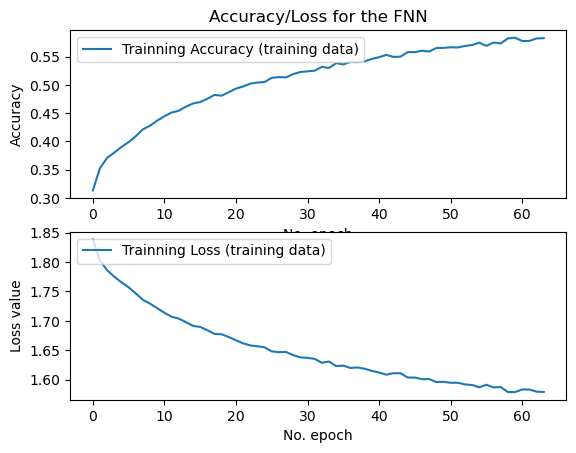

In [15]:
# Plot history
plt.figure()
fig, ax = plt.subplots(2,1)
ax[0].plot(history1.history['accuracy'], label='Trainning Accuracy (training data)')
ax[1].plot(history1.history['loss'], label='Trainning Loss (training data)')
# ax[0].plot(history1.history['val_accuracy'], label='Validation Accuracy (training data)')
# ax[1].plot(history1.history['val_loss'], label='Validation Loss (training data)')
ax[0].set_title('Accuracy/Loss for the FNN')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('No. epoch')
ax[0].legend(loc="upper left")
ax[1].set_ylabel('Loss value')
ax[1].set_xlabel('No. epoch')
ax[1].legend(loc="upper left")
plt.show()

In [16]:
results = model1.evaluate(X_valid, Y_valid)
print("test loss, test acc:", results)
print("Total trainning time: ", (endTime - startTime), "seconds")

113/113 [==============================] - 0s 2ms/step - loss: 1.6994 - accuracy: 0.4588
test loss, test acc: [1.6994346380233765, 0.458751380443573]
Total trainning time:  262.07589650154114 seconds


### Model 2 (FNN) : 
Same layers were same as before but activation are now sigmoid functions. Same callback function is utilized from FNN model 1

In [17]:
model2 = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(48,48,1), batch_size=None),
                              tf.keras.layers.Flatten(),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.15),
                             tf.keras.layers.Dense(500, activation=tf.nn.sigmoid),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.15),
                             tf.keras.layers.Dense(400, activation=tf.nn.sigmoid),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.15)])
model2.add(tf.keras.layers.Dense(len(C.keys()), activation='softmax'))
model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
              , optimizer='Adam', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 2304)              9216      
_________________________________________________________________
dropout_3 (Dropout)          (None, 2304)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               1152500   
_________________________________________________________________
batch_normalization_4 (Batch (None, 500)               2000      
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 400)              

In [18]:
startTime = time.time()
history2 = model2.fit(X, Y, epochs = 250, verbose=1, callbacks = [callback])
endTime = time.time()

Epoch 1/250
898/898 [==============================] - 4s 5ms/step - loss: 1.8687 - accuracy: 0.2847
Epoch 2/250
898/898 [==============================] - 4s 4ms/step - loss: 1.8231 - accuracy: 0.3326
Epoch 3/250
898/898 [==============================] - 4s 4ms/step - loss: 1.8087 - accuracy: 0.3476
Epoch 4/250
898/898 [==============================] - 4s 4ms/step - loss: 1.7982 - accuracy: 0.3577
Epoch 5/250
898/898 [==============================] - 4s 5ms/step - loss: 1.7925 - accuracy: 0.3641
Epoch 6/250
898/898 [==============================] - 4s 4ms/step - loss: 1.7894 - accuracy: 0.3672
Epoch 7/250
898/898 [==============================] - 4s 4ms/step - loss: 1.7883 - accuracy: 0.3674
Epoch 8/250
898/898 [==============================] - 4s 4ms/step - loss: 1.7774 - accuracy: 0.3784
Epoch 9/250
898/898 [==============================] - 4s 5ms/step - loss: 1.7752 - accuracy: 0.3796
Epoch 10/250
898/898 [==============================] - 4s 4ms/step - loss: 1.7706 - accura

<Figure size 640x480 with 0 Axes>

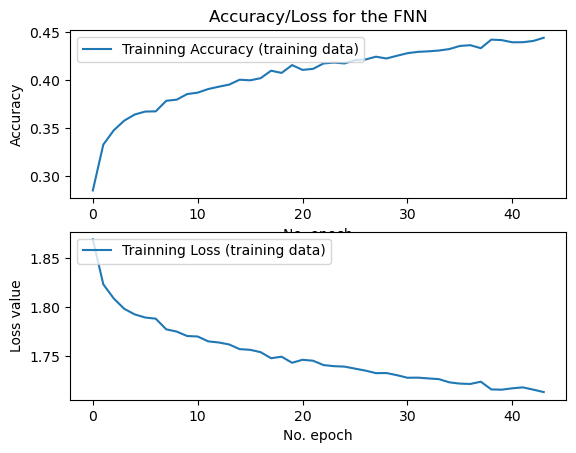

In [19]:
# Plot history
plt.figure()
fig, ax = plt.subplots(2,1)
ax[0].plot(history2.history['accuracy'], label='Trainning Accuracy (training data)')
ax[1].plot(history2.history['loss'], label='Trainning Loss (training data)')
# ax[0].plot(history1.history['val_accuracy'], label='Validation Accuracy (training data)')
# ax[1].plot(history1.history['val_loss'], label='Validation Loss (training data)')
ax[0].set_title('Accuracy/Loss for the FNN')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('No. epoch')
ax[0].legend(loc="upper left")
ax[1].set_ylabel('Loss value')
ax[1].set_xlabel('No. epoch')
ax[1].legend(loc="upper left")
plt.show()

In [20]:
results = model2.evaluate(X_valid, Y_valid)
print("test loss, test acc:", results)
print("Total trainning time: ", (endTime - startTime), "seconds")

113/113 [==============================] - 0s 2ms/step - loss: 1.7494 - accuracy: 0.4044
test loss, test acc: [1.7493516206741333, 0.40440356731414795]
Total trainning time:  184.17514038085938 seconds


### Model 3 (FNN) : 
This time the model has only 1 hidden layer but has increased number of neurons in the hidden layer (keeping the total number of parameters approximately same ~ 1.3 million). Again the same callback functions is utilized for early stopping

In [21]:
model3 = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(48,48,1), batch_size=None),
                              tf.keras.layers.Flatten(),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.15),
                             tf.keras.layers.Dense(600, activation=tf.nn.relu),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.15)])
model3.add(tf.keras.layers.Dense(len(C.keys()), activation='softmax'))
model3.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
              , optimizer='Adam', metrics=['accuracy'])
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 2304)              9216      
_________________________________________________________________
dropout_6 (Dropout)          (None, 2304)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 600)               1383000   
_________________________________________________________________
batch_normalization_7 (Batch (None, 600)               2400      
_________________________________________________________________
dropout_7 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                

In [22]:
startTime = time.time()
history3 = model3.fit(X, Y, epochs = 250, verbose=1, callbacks = [callback])
endTime = time.time()

Epoch 1/250
898/898 [==============================] - 3s 4ms/step - loss: 1.8372 - accuracy: 0.3158
Epoch 2/250
898/898 [==============================] - 3s 4ms/step - loss: 1.7895 - accuracy: 0.3661
Epoch 3/250
898/898 [==============================] - 3s 4ms/step - loss: 1.7750 - accuracy: 0.3817
Epoch 4/250
898/898 [==============================] - 3s 4ms/step - loss: 1.7649 - accuracy: 0.3915
Epoch 5/250
898/898 [==============================] - 3s 4ms/step - loss: 1.7580 - accuracy: 0.3990
Epoch 6/250
898/898 [==============================] - 3s 4ms/step - loss: 1.7471 - accuracy: 0.4093
Epoch 7/250
898/898 [==============================] - 3s 4ms/step - loss: 1.7403 - accuracy: 0.4182
Epoch 8/250
898/898 [==============================] - 3s 4ms/step - loss: 1.7308 - accuracy: 0.4267
Epoch 9/250
898/898 [==============================] - 3s 4ms/step - loss: 1.7245 - accuracy: 0.4350
Epoch 10/250
898/898 [==============================] - 3s 4ms/step - loss: 1.7178 - accura

898/898 [==============================] - 3s 4ms/step - loss: 1.5556 - accuracy: 0.6071
Epoch 82/250
898/898 [==============================] - 4s 4ms/step - loss: 1.5561 - accuracy: 0.6064
Epoch 83/250
898/898 [==============================] - 3s 4ms/step - loss: 1.5550 - accuracy: 0.6082


<Figure size 640x480 with 0 Axes>

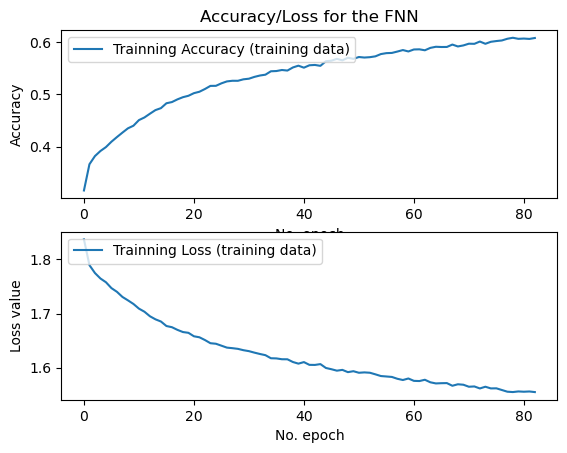

In [23]:
# Plot history
plt.figure()
fig, ax = plt.subplots(2,1)
ax[0].plot(history3.history['accuracy'], label='Trainning Accuracy (training data)')
ax[1].plot(history3.history['loss'], label='Trainning Loss (training data)')
# ax[0].plot(history1.history['val_accuracy'], label='Validation Accuracy (training data)')
# ax[1].plot(history1.history['val_loss'], label='Validation Loss (training data)')
ax[0].set_title('Accuracy/Loss for the FNN')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('No. epoch')
ax[0].legend(loc="upper left")
ax[1].set_ylabel('Loss value')
ax[1].set_xlabel('No. epoch')
ax[1].legend(loc="upper left")
plt.show()

In [24]:
results = model3.evaluate(X_valid, Y_valid)
print("test loss, test acc:", results)
print("Total trainning time: ", (endTime - startTime), "seconds")

113/113 [==============================] - 0s 2ms/step - loss: 1.6965 - accuracy: 0.4657
test loss, test acc: [1.6964530944824219, 0.465719074010849]
Total trainning time:  271.9993920326233 seconds


Thus out of the three models, the first model with 1 hidden layers but increased neurons, performed the best on validation set accuracy of 46.57%.

### (c.ii) (1 point)
Run the best model that was found based on the validation set from question (c.i) on the testing set. Report the emotion classification accuracy on the testing set.

In [25]:
result1_final = model3.evaluate(X_test, Y_test)
print("test loss, test acc:", result1_final)

113/113 [==============================] - 0s 2ms/step - loss: 1.7050 - accuracy: 0.4543
test loss, test acc: [1.705011248588562, 0.45429208874702454]


### (d) (4 points) Image classification with CNNs: 
In this part, you will use a convolutional
neural network (CNN) to perform the emotion classification task.

### (d.i) (3 points)
Experiment on the validation set with different CNN hyper-parameters, e.g. #layers, filter size, stride size, activation function, dropout, weight regularization, etc. For each hyper-parameter combination that you have used, please report the following: (1) emotion classification accuracy on the training and validation sets; (2) running time for training the FNN; (3) # parameters for each CNN. How do these metrics compare to the FNN?

### Note:
In the next few CNN, the number of parameters are kept approximately same as what was for FNNs (1.3 million). Along with the easy of execution, this was also done to compare the accuracies directly, keeping the total number of parameters constant.


### Model 1:
The first CNN model has 64 filter Conv layer of kernel size 3, then a max pooling layer of size 2 followed by another Conv layer of 32 filters of kernel size 3 and max pooling layer of size 2. Both the conv layers had activation function of Relu. Then comes the fully connected layer with two hidden layers 375 and 350 neurons respectively, with activation function of Relu.

In [26]:
model4 = tf.keras.Sequential([tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48,48,1)),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.15),
                              tf.keras.layers.MaxPooling2D((2, 2)),
                              tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.15),
                              tf.keras.layers.MaxPooling2D((2, 2)),
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(375, activation=tf.nn.relu),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.15),
                              tf.keras.layers.Dense(350, activation=tf.nn.relu),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.15)])
model4.add(tf.keras.layers.Dense(len(C.keys()), activation='softmax'))
model4.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
              , optimizer='Adam', metrics=['accuracy'])
print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_8 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
dropout_8 (Dropout)          (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        18464     
_________________________________________________________________
batch_normalization_9 (Batch (None, 21, 21, 32)        128       
_________________________________________________________________
dropout_9 (Dropout)          (None, 21, 21, 32)       

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=7, min_delta=0.002)
startTime = time.time()
history4 = model4.fit(X, Y, epochs = 250, verbose=1, callbacks = [callback])
endTime = time.time()

Epoch 1/250
898/898 [==============================] - 7s 8ms/step - loss: 1.7995 - accuracy: 0.3548
Epoch 2/250
898/898 [==============================] - 7s 8ms/step - loss: 1.7378 - accuracy: 0.4185
Epoch 3/250
898/898 [==============================] - 7s 8ms/step - loss: 1.7092 - accuracy: 0.4470
Epoch 4/250
898/898 [==============================] - 7s 8ms/step - loss: 1.6868 - accuracy: 0.4713
Epoch 5/250
898/898 [==============================] - 7s 8ms/step - loss: 1.6698 - accuracy: 0.4890
Epoch 6/250
898/898 [==============================] - 7s 8ms/step - loss: 1.6541 - accuracy: 0.5060
Epoch 7/250
898/898 [==============================] - 7s 8ms/step - loss: 1.6447 - accuracy: 0.5148
Epoch 8/250
898/898 [==============================] - 7s 8ms/step - loss: 1.6404 - accuracy: 0.5188
Epoch 9/250
898/898 [==============================] - 7s 8ms/step - loss: 1.6290 - accuracy: 0.5307
Epoch 10/250
898/898 [==============================] - 7s 8ms/step - loss: 1.6087 - accura

898/898 [==============================] - 7s 8ms/step - loss: 1.3699 - accuracy: 0.7944
Epoch 82/250
898/898 [==============================] - 7s 8ms/step - loss: 1.3682 - accuracy: 0.7956
Epoch 83/250
898/898 [==============================] - 7s 8ms/step - loss: 1.3549 - accuracy: 0.8097
Epoch 84/250
898/898 [==============================] - 7s 8ms/step - loss: 1.3701 - accuracy: 0.7939
Epoch 85/250
898/898 [==============================] - 7s 8ms/step - loss: 1.3613 - accuracy: 0.8025
Epoch 86/250
898/898 [==============================] - 7s 8ms/step - loss: 1.3676 - accuracy: 0.7965
Epoch 87/250
898/898 [==============================] - 7s 8ms/step - loss: 1.3653 - accuracy: 0.7990
Epoch 88/250
898/898 [==============================] - 7s 8ms/step - loss: 1.3589 - accuracy: 0.8051
Epoch 89/250
898/898 [==============================] - 7s 8ms/step - loss: 1.3586 - accuracy: 0.8054
Epoch 90/250
898/898 [==============================] - 7s 8ms/step - loss: 1.3636 - accuracy: 

<Figure size 640x480 with 0 Axes>

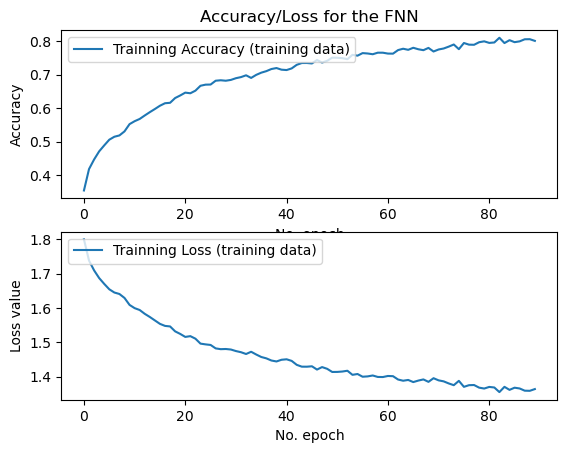

In [28]:
# Plot history
plt.figure()
fig, ax = plt.subplots(2,1)
ax[0].plot(history4.history['accuracy'], label='Trainning Accuracy (training data)')
ax[1].plot(history4.history['loss'], label='Trainning Loss (training data)')
# ax[0].plot(history1.history['val_accuracy'], label='Validation Accuracy (training data)')
# ax[1].plot(history1.history['val_loss'], label='Validation Loss (training data)')
ax[0].set_title('Accuracy/Loss for the FNN')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('No. epoch')
ax[0].legend(loc="upper left")
ax[1].set_ylabel('Loss value')
ax[1].set_xlabel('No. epoch')
ax[1].legend(loc="upper left")
plt.show()

In [29]:
results = model4.evaluate(X_valid, Y_valid)
print("test loss, test acc:", results)
print("Total trainning time: ", (endTime - startTime), "seconds")

113/113 [==============================] - 0s 3ms/step - loss: 1.6243 - accuracy: 0.5340
test loss, test acc: [1.6243261098861694, 0.5340022444725037]
Total trainning time:  649.8445291519165 seconds


### Model 2 (CNN) :
The second CNN model has 64 filter Conv layer of kernel size 3, then a max pooling layer of size 2 followed by another Conv layer of 32 filters of kernel size 3 and max pooling layer of size 2. Both the conv layers had activation function of Relu. Then comes the fully connected layer with one hidden layers 425 neurons, with activation function of sigmoid.

In [30]:
model5 = tf.keras.Sequential([tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48,48,1)),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.15),
                              tf.keras.layers.MaxPooling2D((2, 2)),
                              tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.15),
                              tf.keras.layers.MaxPooling2D((2, 2)),
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(425, activation=tf.nn.sigmoid),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.15),])
model5.add(tf.keras.layers.Dense(len(C.keys()), activation='softmax'))
model5.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
              , optimizer='Adam', metrics=['accuracy'])
print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_12 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
dropout_12 (Dropout)         (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 32)        18464     
_________________________________________________________________
batch_normalization_13 (Batc (None, 21, 21, 32)        128       
_________________________________________________________________
dropout_13 (Dropout)         (None, 21, 21, 32)       

In [31]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=7, min_delta=0.002)
startTime = time.time()
history5 = model5.fit(X, Y, epochs = 250, verbose=1, callbacks = [callback])
endTime = time.time()

Epoch 1/250
898/898 [==============================] - 7s 7ms/step - loss: 1.7729 - accuracy: 0.3818
Epoch 2/250
898/898 [==============================] - 7s 7ms/step - loss: 1.7016 - accuracy: 0.4537
Epoch 3/250
898/898 [==============================] - 7s 7ms/step - loss: 1.6736 - accuracy: 0.4849
Epoch 4/250
898/898 [==============================] - 7s 7ms/step - loss: 1.6491 - accuracy: 0.5105
Epoch 5/250
898/898 [==============================] - 7s 7ms/step - loss: 1.6297 - accuracy: 0.5311
Epoch 6/250
898/898 [==============================] - 7s 7ms/step - loss: 1.6122 - accuracy: 0.5482
Epoch 7/250
898/898 [==============================] - 7s 7ms/step - loss: 1.5938 - accuracy: 0.5678: 0s - loss: 1.5928 
Epoch 8/250
898/898 [==============================] - 7s 7ms/step - loss: 1.5762 - accuracy: 0.5867
Epoch 9/250
898/898 [==============================] - 7s 7ms/step - loss: 1.5625 - accuracy: 0.6010
Epoch 10/250
898/898 [==============================] - 7s 7ms/step - l

898/898 [==============================] - 7s 7ms/step - loss: 1.3330 - accuracy: 0.8319
Epoch 82/250
898/898 [==============================] - 7s 7ms/step - loss: 1.3306 - accuracy: 0.8341
Epoch 83/250
898/898 [==============================] - 7s 7ms/step - loss: 1.3271 - accuracy: 0.8381
Epoch 84/250
898/898 [==============================] - 7s 7ms/step - loss: 1.3281 - accuracy: 0.8363
Epoch 85/250
898/898 [==============================] - 7s 7ms/step - loss: 1.3269 - accuracy: 0.8378
Epoch 86/250
898/898 [==============================] - 7s 7ms/step - loss: 1.3229 - accuracy: 0.8417
Epoch 87/250
898/898 [==============================] - 7s 7ms/step - loss: 1.3207 - accuracy: 0.8441
Epoch 88/250
898/898 [==============================] - 7s 7ms/step - loss: 1.3219 - accuracy: 0.8425
Epoch 89/250
898/898 [==============================] - 7s 7ms/step - loss: 1.3233 - accuracy: 0.8410
Epoch 90/250
898/898 [==============================] - 7s 7ms/step - loss: 1.3232 - accuracy: 

<Figure size 640x480 with 0 Axes>

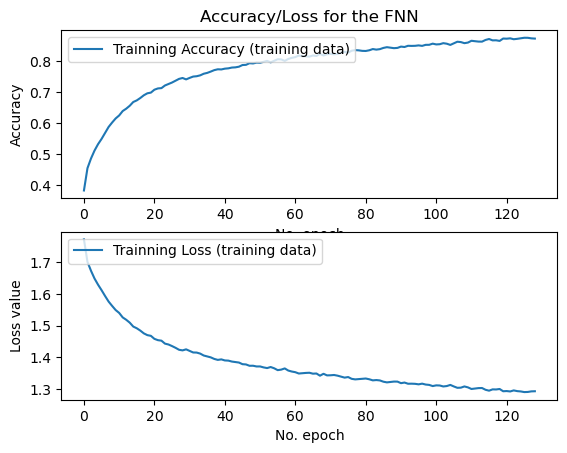

In [32]:
# Plot history
plt.figure()
fig, ax = plt.subplots(2,1)
ax[0].plot(history5.history['accuracy'], label='Trainning Accuracy (training data)')
ax[1].plot(history5.history['loss'], label='Trainning Loss (training data)')
# ax[0].plot(history1.history['val_accuracy'], label='Validation Accuracy (training data)')
# ax[1].plot(history1.history['val_loss'], label='Validation Loss (training data)')
ax[0].set_title('Accuracy/Loss for the FNN')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('No. epoch')
ax[0].legend(loc="upper left")
ax[1].set_ylabel('Loss value')
ax[1].set_xlabel('No. epoch')
ax[1].legend(loc="upper left")
plt.show()

In [33]:
results = model5.evaluate(X_valid, Y_valid)
print("test loss, test acc:", results)
print("Total trainning time: ", (endTime - startTime), "seconds")

113/113 [==============================] - 0s 3ms/step - loss: 1.6244 - accuracy: 0.5354
test loss, test acc: [1.6244301795959473, 0.5353957414627075]
Total trainning time:  849.2923784255981 seconds


### Model 3 (CNN) :
The third CNN model has 64 filter Conv layer of kernel size 3, then a max pooling layer of size 2 followed by another Conv layer of 32 filters of kernel size 3 and max pooling layer of size 2. Both the conv layers had activation function of Relu. Then comes the fully connected layer with two hidden layers 450 and 350 neurons respectively, with activation function of sigmoid.)

In [34]:
model6 = tf.keras.Sequential([tf.keras.layers.Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.15),
                              tf.keras.layers.MaxPooling2D((2, 2)),
                              tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.15),
                              tf.keras.layers.MaxPooling2D((2, 2)),
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(450, activation=tf.nn.sigmoid),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.15),
                              tf.keras.layers.Dense(350, activation=tf.nn.sigmoid),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.15)])
model6.add(tf.keras.layers.Dense(len(C.keys()), activation='softmax'))
model6.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
              , optimizer='Adam', metrics=['accuracy'])
print(model6.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
batch_normalization_15 (Batc (None, 44, 44, 64)        256       
_________________________________________________________________
dropout_15 (Dropout)         (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 18, 32)        51232     
_________________________________________________________________
batch_normalization_16 (Batc (None, 18, 18, 32)        128       
_________________________________________________________________
dropout_16 (Dropout)         (None, 18, 18, 32)       

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=7, min_delta=0.002)
startTime = time.time()
history6 = model6.fit(X, Y, epochs = 250, verbose=1, callbacks = [callback])
endTime = time.time()

Epoch 1/250
898/898 [==============================] - 7s 8ms/step - loss: 1.8277 - accuracy: 0.3281
Epoch 2/250
898/898 [==============================] - 7s 8ms/step - loss: 1.7813 - accuracy: 0.3750
Epoch 3/250
898/898 [==============================] - 7s 8ms/step - loss: 1.7630 - accuracy: 0.3946
Epoch 4/250
898/898 [==============================] - 7s 8ms/step - loss: 1.7567 - accuracy: 0.4002
Epoch 5/250
898/898 [==============================] - 7s 8ms/step - loss: 1.7425 - accuracy: 0.4139
Epoch 6/250
898/898 [==============================] - 7s 8ms/step - loss: 1.7258 - accuracy: 0.4322
Epoch 7/250
898/898 [==============================] - 7s 8ms/step - loss: 1.7191 - accuracy: 0.4375
Epoch 8/250
898/898 [==============================] - 7s 8ms/step - loss: 1.7021 - accuracy: 0.4566
Epoch 9/250
898/898 [==============================] - 7s 8ms/step - loss: 1.6894 - accuracy: 0.4691
Epoch 10/250
898/898 [==============================] - 7s 8ms/step - loss: 1.6834 - accura

898/898 [==============================] - 7s 8ms/step - loss: 1.4692 - accuracy: 0.6938
Epoch 82/250
898/898 [==============================] - 7s 8ms/step - loss: 1.4715 - accuracy: 0.6914
Epoch 83/250
898/898 [==============================] - 7s 8ms/step - loss: 1.4700 - accuracy: 0.6928
Epoch 84/250
898/898 [==============================] - 7s 8ms/step - loss: 1.4649 - accuracy: 0.6983
Epoch 85/250
898/898 [==============================] - 7s 8ms/step - loss: 1.4632 - accuracy: 0.7006
Epoch 86/250
898/898 [==============================] - 7s 8ms/step - loss: 1.4617 - accuracy: 0.7017
Epoch 87/250
898/898 [==============================] - 7s 8ms/step - loss: 1.4653 - accuracy: 0.6982
Epoch 88/250
898/898 [==============================] - 7s 8ms/step - loss: 1.4653 - accuracy: 0.6981
Epoch 89/250
898/898 [==============================] - 7s 8ms/step - loss: 1.4640 - accuracy: 0.6989
Epoch 90/250
898/898 [==============================] - 7s 8ms/step - loss: 1.4613 - accuracy: 

<Figure size 640x480 with 0 Axes>

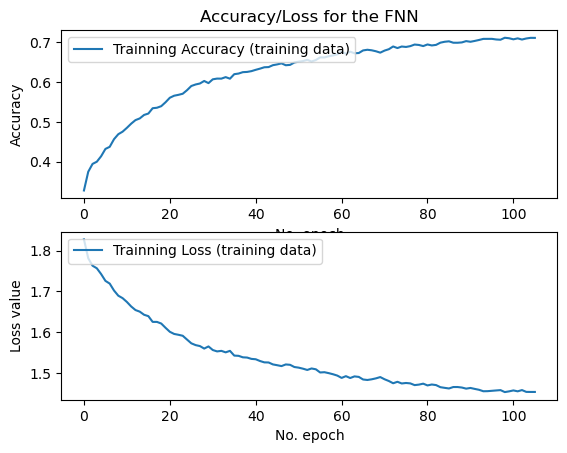

In [36]:
# Plot history
plt.figure()
fig, ax = plt.subplots(2,1)
ax[0].plot(history6.history['accuracy'], label='Trainning Accuracy (training data)')
ax[1].plot(history6.history['loss'], label='Trainning Loss (training data)')
# ax[0].plot(history1.history['val_accuracy'], label='Validation Accuracy (training data)')
# ax[1].plot(history1.history['val_loss'], label='Validation Loss (training data)')
ax[0].set_title('Accuracy/Loss for the FNN')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('No. epoch')
ax[0].legend(loc="upper left")
ax[1].set_ylabel('Loss value')
ax[1].set_xlabel('No. epoch')
ax[1].legend(loc="upper left")
plt.show()

In [37]:
results = model6.evaluate(X_valid, Y_valid)
print("test loss, test acc:", results)
print("Total trainning time: ", (endTime - startTime), "seconds")

113/113 [==============================] - 0s 3ms/step - loss: 1.6471 - accuracy: 0.5128
test loss, test acc: [1.647139072418213, 0.5128205418586731]
Total trainning time:  727.9486835002899 seconds


### (d.ii) (1 point) 
Run the best model that was found based on the validation set from question (d.i) on the testing set. Report the emotion classification accuracy on the testing set. How does this metric compare to the FNN?

In [38]:
result2_final = model5.evaluate(X_test, Y_test)
print("test loss, test acc:", result1_final)

113/113 [==============================] - 0s 3ms/step - loss: 1.6180 - accuracy: 0.5460
test loss, test acc: [1.705011248588562, 0.45429208874702454]


### (g) (Bonus - 1 point) Data augmentation:
Data augmentation is a way to increase the size of our dataset and reduce overfitting, especially when we use complicated models with many parameters to learn. Using any available toolbox or your own code, implement some of these techniques and augment the original FER data.

### Augmented Data set:
The augmented set below generates a new image by rotation (from -30 degrees to +30 degrees), Shifting horizontally or vertically and completely flipping the image). A total of 1000 new images have been generated from a sample of 5000 original images. Only 5000 were chosen, since my computer didnt have enough resources to use the complete dataset.

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [40]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
datagen.fit(X)

In [41]:
X_aug  = []
Y_aug = []
for X_batch, y_batch in datagen.flow(X[:5000], Y[:5000], batch_size=1000):
    for i in range(1000):
        max_ele = X_batch[i].max()
        min_ele = X_batch[i].min()
        X_batch[i] = (X_batch[i]-min_ele)/(max_ele - min_ele + 0.000000000001)
        X_aug.append(X_batch[i])
        Y_aug.append(y_batch[i])
    break

In [42]:
X_aug = np.array(X_aug)
X_aug = X_aug.reshape(X_aug.shape[0], 48, 48, 1)
Y_aug = tf.keras.utils.to_categorical(Y_aug, 7)

In [43]:
X_aug.shape

(1000, 48, 48, 1)

### (e) (1 point) Bayesian optimization for hyper-parameter tuning:
Instead of performing grid or random search to tune the hyper-parameters of the CNN, we can also try a model-based method for finding the optimal hyper-parameters through Bayesian optimization. This method performs a more intelligent search on the hyper-parameter space in order to estimate the best set of hyper-parameters for the data. Use publicly available libraries (e.g., hyperopt in Python) to perform a Bayesian optimization on the hyper-parameter space using the validation set. Re-port the emotion classification accuracy on the testing set.

### Soln:
For the code below, the first model of CNN has been taken. The parameters searched are dropuout probablities (ranging from 0.1 to 0.35) and kernel size for convolutions (ranging from 1x3 or 3x3).

In [46]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical 

def optimize_cnn(hyperparameter):
  
  # Define model using hyperparameters
    cnn_model = tf.keras.Sequential([tf.keras.layers.Conv2D(64, kernel_size=hyperparameter['conv_kernel_size'], activation='relu', input_shape=(48,48,1)),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(rate = hyperparameter['dropout_prob']),
                              tf.keras.layers.MaxPooling2D(pool_size=hyperparameter['conv_kernel_size']),
                              tf.keras.layers.Conv2D(32, kernel_size=hyperparameter['conv_kernel_size'], activation='relu'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(rate=hyperparameter['dropout_prob']),
                              tf.keras.layers.MaxPooling2D(pool_size=hyperparameter['conv_kernel_size']),
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(425, activation=tf.nn.sigmoid),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(rate = hyperparameter['dropout_prob']),])
    cnn_model.add(tf.keras.layers.Dense(7, activation='softmax'))
  
    cnn_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'],)

    train_X, train_y = X, Y
    valid_X, valid_y = X_valid, Y_valid

    cnn_model.fit(train_X, train_y, epochs=100, batch_size=256, verbose=0)
  # Evaluate accuracy on validation data
    performance = cnn_model.evaluate(valid_X, valid_y, verbose=0)

    print("Hyperparameters: ", hyperparameter, "Accuracy: ", performance[1])
    print("----------------------------------------------------")
    return({"status": STATUS_OK, "loss": -1*performance[1], "model":cnn_model})
  

# Define search space for hyper-parameters
space = {
    # The kernel_size for convolutions:
    'conv_kernel_size': hp.choice('conv_kernel_size', [1,3]),
    # Uniform distribution in finding appropriate dropout values
    'dropout_prob': hp.choice('dropout_prob', [0.1, 0.2, 0.3]),
}

trials = Trials()

# Find the best hyperparameters
best = fmin(
        optimize_cnn,
        space,
        algo=tpe.suggest,
        trials=trials,
        max_evals=5,
    )

print("==================================")
print("Best Hyperparameters", best)

# Find trial which has minimum loss value and use that model to perform evaluation on the test data
test_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

performance = test_model.evaluate(X_test, Y_test)

print("==================================")
print("Test Accuracy: ", performance[1])

Hyperparameters:                                     
{'conv_kernel_size': 1, 'dropout_prob': 0.1}         
Accuracy:                                            
0.39966556429862976                                  
---------------------------------------------------- 
Hyperparameters:                                                                  
{'conv_kernel_size': 3, 'dropout_prob': 0.1}                                      
Accuracy:                                                                         
0.5490524172782898                                                                
----------------------------------------------------                              
Hyperparameters:                                                                  
{'conv_kernel_size': 3, 'dropout_prob': 0.2}                                     
Accuracy:                                                                        
0.5618728995323181                                                  

ValueError: Data cardinality is ambiguous:
  x sizes: 3588
  y sizes: 1000
Please provide data which shares the same first dimension.

In [48]:
performance = test_model.evaluate(X_test, Y_test)

print("==================================")
print("Test Accuracy: ", performance[1])

113/113 [==============================] - 1s 5ms/step - loss: 1.9133 - accuracy: 0.5510
Test Accuracy:  0.5510033369064331
